<a href="https://colab.research.google.com/github/yohan-th/21sh/blob/master/Cryptotrend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytrends cryptocompare

  Created wheel for cryptocompare: filename=cryptocompare-0.7.5-cp37-none-any.whl size=5063 sha256=fdfcd9b297ccd69a9c67905ff6a9a53009b8b046f947853e7cf6f207a5e8f882
  Stored in directory: /root/.cache/pip/wheels/7b/99/20/41d3f0208616784be594768edd6b34610aa5035f41ce023fa6
Successfully built cryptocompare


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import time
import os.path

pd.set_option('display.max_rows', 9999)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/cryptotrend'
!ls

Mounted at /content/drive
drive  sample_data


# Tools

In [ ]:
from datetime import datetime, timedelta, date

def split_date(bgn, end, max_day_delta):
  split_bgn = re.split('-', bgn)
  split_bgn = [ int(x) for x in split_bgn ]
  d0 = date(split_bgn[0], split_bgn[1], split_bgn[2])

  split_end = re.split('-', end)
  split_end = [ int(x) for x in split_end ]
  d1 = date(split_end[0], split_end[1], split_end[2])

  delta = d1 - d0

  dates = []
  if delta.days >= max_day_delta:
    while delta.days >= max_day_delta:
      d0_delta = d0 + timedelta(days=max_day_delta-1)
      dates.append((d0, d0_delta))
      d0 = d0_delta
      delta = d1 - d0
  dates.append((d0, d1))
  return dates

#print(split_date('2021-01-30', '2021-02-03', 2))

## [Crypt]

In [ ]:
def calc_moyenne_crypto(crypto):
  i = 0
  lh1 = []
  lh2 = []
  lh3 = []
  lh6 = []

  for index, row in crypto.iterrows():

      if i >= 1:
        h1 = ((crypto['open'][i] - crypto['open'][i - 1])/crypto['open'][i - 1])*100
      else: 
        h1 = 0
      lh1.append(round(h1))

      if i >= 2:
        v1 = ((crypto['open'][i] - crypto['open'][i - 1])/crypto['open'][i - 1])*100
        v2 = ((crypto['open'][i - 1] - crypto['open'][i - 2])/crypto['open'][i - 2])*100
        h2 = (v1 + v2) / 2
      else: 
        h2 = 0
      lh2.append(round(h2))

      if i >= 3:
        v1 = ((crypto['open'][i] - crypto['open'][i - 1])/crypto['open'][i - 1])*100
        v2 = ((crypto['open'][i - 1] - crypto['open'][i - 2])/crypto['open'][i - 2])*100
        v3 = ((crypto['open'][i - 2] - crypto['open'][i - 3])/crypto['open'][i - 3])*100
        h3 = (v1 + v2 + v3) / 3
      else: 
        h3 = 0
      lh3.append(round(h3))
      
      if i >= 6:
        v1 = ((crypto['open'][i] - crypto['open'][i - 1])/crypto['open'][i - 1])*100
        v2 = ((crypto['open'][i - 1] - crypto['open'][i - 2])/crypto['open'][i - 2])*100
        v3 = ((crypto['open'][i - 2] - crypto['open'][i - 3])/crypto['open'][i - 3])*100
        v4 = ((crypto['open'][i - 3] - crypto['open'][i - 4])/crypto['open'][i - 4])*100
        v5 = ((crypto['open'][i - 4] - crypto['open'][i - 5])/crypto['open'][i - 5])*100
        v6 = ((crypto['open'][i - 5] - crypto['open'][i - 6])/crypto['open'][i - 6])*100
        h6 = (v1 + v2 + v3 + v4 + v5 + v6) / 6
      else: 
        h6 = 0
      lh6.append(round(h6))

      i += 1

  crypto['h1'] = pd.Series(lh1, index=crypto.index)
  crypto['h2'] = pd.Series(lh2, index=crypto.index)
  crypto['h3'] = pd.Series(lh3, index=crypto.index)
  crypto['h6'] = pd.Series(lh6, index=crypto.index)

  return crypto

In [ ]:
import cryptocompare

def get_crypto(d0, d1, cur1, cur2):
  dates = split_date(d0, d1, 30*2) #l'API repond que sur des tranches de 3 mois
  pd_crypto = []
  for date in dates:
    bgn, end = date
    delta = end - bgn
    if os.path.isfile(f'{path}/crypto/{cur1}-{cur2}_{bgn}_{end}'):
      crypto = pd.read_csv(f'{path}/crypto/{cur1}-{cur2}_{bgn}_{end}')
    else:
      print('Get API crypto')
      crypto = cryptocompare.get_historical_price_hour(cur1, currency=cur2, limit=24*delta.days, toTs=end)
      crypto = pd.DataFrame(crypto)
      crypto.to_csv(f'{path}/crypto/{cur1}-{cur2}_{bgn}_{end}') 
    if len(pd_crypto) > 0: #ur de la premier ligne qui est deja dans la deriner pd
      crypto = crypto.drop(0)
    pd_crypto.append(crypto)
  
  crypto = pd.concat(pd_crypto).reset_index()
  crypto['time'] = pd.to_datetime(crypto['time'], unit='s')
  crypto = calc_moyenne_crypto(crypto)

  return crypto
  #print(crypto)

  #plt.figure(figsize=(15, 6))
  #plt.plot(crypto['time'],crypto['close'])


# bgn = '2021-02-01'
# end = '2021-03-01'
# currency = 'XRP'
# base_currency = 'EUR'
# crypto = get_crypto(bgn, end, currency, base_currency)


## [Trend]

### tools calc_moyenne_trend

In [ ]:
def calc_moyenne_trend(trend, curr):
  i = 0
  lh1 = []
  lh2 = []
  lh3 = []
  lh6 = []
  lh9 = []
  lh12 = []

  for index, row in trend.iterrows():
      if i >= 1:
        h1 = trend[curr][i] - trend[curr][i - 1]
      else: 
        h1 = 0
      lh1.append(round(h1))

      if i >= 2:
        v1 = trend[curr][i] - trend[curr][i - 1]
        v2 = trend[curr][i - 1] - trend[curr][i - 2]
        h2 = (v1 + v2) / 2
      else: 
        h2 = 0
      lh2.append(round(h2))

      if i >= 3:
        v1 = trend[curr][i] - trend[curr][i - 1]
        v2 = trend[curr][i - 1] - trend[curr][i - 2]
        v3 = trend[curr][i - 2] - trend[curr][i - 3]
        h3 = (v1 + v2 + v3) / 3
      else: 
        h3 = 0
      lh3.append(round(h3))
      
      if i >= 6:
        v1 = trend[curr][i] - trend[curr][i - 1]
        v2 = trend[curr][i - 1] - trend[curr][i - 2]
        v3 = trend[curr][i - 2] - trend[curr][i - 3]
        v4 = trend[curr][i - 3] - trend[curr][i - 4]
        v5 = trend[curr][i - 4] - trend[curr][i - 5]
        v6 = trend[curr][i - 5] - trend[curr][i - 6]
        h6 = (v1 + v2 + v3 + v4 + v5 + v6) / 6
      else: 
        h6 = 0
      lh6.append(round(h6))

      if i >= 9:
        v1 = trend[curr][i] - trend[curr][i - 1]
        v2 = trend[curr][i - 1] - trend[curr][i - 2]
        v3 = trend[curr][i - 2] - trend[curr][i - 3]
        v4 = trend[curr][i - 3] - trend[curr][i - 4]
        v5 = trend[curr][i - 4] - trend[curr][i - 5]
        v6 = trend[curr][i - 5] - trend[curr][i - 6]
        v7 = trend[curr][i - 6] - trend[curr][i - 7]
        v8 = trend[curr][i - 7] - trend[curr][i - 8]
        v9 = trend[curr][i - 8] - trend[curr][i - 9]
        h9 = (v1 + v2 + v3 + v4 + v5 + v6 + v7 + v8 + v9) / 9
      else: 
        h9 = 0
      lh9.append(round(h9))

      if i >= 12:
        v1 = trend[curr][i] - trend[curr][i - 1]
        v2 = trend[curr][i - 1] - trend[curr][i - 2]
        v3 = trend[curr][i - 2] - trend[curr][i - 3]
        v4 = trend[curr][i - 3] - trend[curr][i - 4]
        v5 = trend[curr][i - 4] - trend[curr][i - 5]
        v6 = trend[curr][i - 5] - trend[curr][i - 6]
        v7 = trend[curr][i - 6] - trend[curr][i - 7]
        v8 = trend[curr][i - 7] - trend[curr][i - 8]
        v9 = trend[curr][i - 8] - trend[curr][i - 9]
        v10 = trend[curr][i - 9] - trend[curr][i - 10]
        v11 = trend[curr][i - 10] - trend[curr][i - 11]
        v12 = trend[curr][i - 11] - trend[curr][i - 12]
        h12 = (v1 + v2 + v3 + v4 + v5 + v6) / 12
      else: 
        h12 = 0
      lh12.append(round(h12))

      i += 1
  trend['h1'] = pd.Series(lh1, index=trend.index)
  trend['h2'] = pd.Series(lh2, index=trend.index)
  trend['h3'] = pd.Series(lh3, index=trend.index)
  trend['h6'] = pd.Series(lh6, index=trend.index)
  trend['h9'] = pd.Series(lh9, index=trend.index)
  trend['h12'] = pd.Series(lh12, index=trend.index)

  return trend

### get  Google trend

In [ ]:
def construct_empty_data(d0, d1, words): #because API can be down
  print(f'Google API down for {d0} and {d1} for {words}')
  empty_df = pd.date_range(start=d0, end=d1, freq='1H')
  df = pd.DataFrame(empty_df, columns=['date'])
  df.set_index('date', inplace=True)
  df[words] = 0
  df['h1'] = 0
  df['h2'] = 0
  df['h3'] = 0
  df['h6'] = 0
  df['h9'] = 0
  df['h12'] = 0
  return df


In [ ]:
from pytrends.request import TrendReq
pytrends = TrendReq()

def get_trend(bgn, end, trend_words):
  kw_list = [trend_words]

  dates = split_date(bgn, end, 7) #l'API repond que sur des tranches de 8 jours
  pd_trend = []
  for date in dates:
    bgn, end = date
    if (end - bgn).days < 3: #Pour etre sur d'avoir les trend en heure et pas minute
      tframe = bgn.strftime("%Y-%m-%dT00")+(end + timedelta(days=2)).strftime(" %Y-%m-%dT00")
    else:
      tframe = bgn.strftime("%Y-%m-%dT00")+end.strftime(" %Y-%m-%dT00")
    if os.path.isfile(f'{path}/trend/{trend_words}_{bgn}_{end}'):
      trend = pd.read_csv(f'{path}/trend/{trend_words}_{bgn}_{end}', index_col='date', parse_dates=True)
    else:
      print(f'Get API trend: {trend_words}_{bgn}_{end}')
      pytrends.build_payload(kw_list, cat=0, timeframe=tframe, geo='', gprop='')
      if len(pytrends.interest_over_time()) == 0:
        trend = construct_empty_data(bgn, end, trend_words)
      else:
        trend = pytrends.interest_over_time().drop(columns=['isPartial'])
      trend.to_csv(f'{path}/trend/{trend_words}_{bgn}_{end}') 
    
    if (end - bgn).days < 3:
      jump_first = True #del les days extra d'une maniere non classe
      for index, row in trend.iterrows():
        if index >= end and jump_first == False:
          trend = trend.drop(index)
        elif index >= end and jump_first == True:
          jump_first = False
    if len(pd_trend) > 0: #doublon de miniuit
      trend = trend.iloc[1:]
    pd_trend.append(trend)
  trend = pd.concat(pd_trend)
  trend = calc_moyenne_trend(trend, trend_words)
  return trend

#plt.figure(figsize=(15, 6))
#plt.plot(trend.index,trend[var1])
#XRP coin_2020-03-01_2020-03-07
# bgn = '2020-03-12' #<3 jours au quart d'heure pres, >3 <8 heure
# end = '2020-03-17'
# get_trend(bgn, end, 'XRP coin')

## [Arbitre]

In [ ]:
import sys

class colors:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'


  
  #trend_h2 = [(5, 15), (0, 5), (0, 5), (0, 5), (0, 5)]
  #trend_h1 = [(5, 15), (0, 5), (0, 5), (0, 5), (0, 5)]
  # for trend_h in [trend_h1, trend_h2, trend_h3]
  #   for th in range(5, 15):
  #     trend_h[0] = th
  #     arbitrage
      # for ch1 in range(0, 5):
      #   trend_h[1] = ch1
        # for ch2 in range(0, 5):
        #   trend_h[2] = ch2
        #   for ch3 in range(0, 5):
        #     trend_h[3] = ch3
        #     for ch4 in range(0, 5):
        #       trend_h[4] = ch4


def arbitrage(debug, whistle):
  if len(trend) !=  len(crypto):
    print('Taille trend et crypto different')
    sys.exit()

  place_order = False
  top_value = 0
  low_value = 9999999
  place_value = 0
  order = []
  gain = []

  i = 0
  for index, row in trend.iterrows():
    if crypto['open'][i] > top_value:
      top_value = crypto['open'][i]
    if  i > 1 and crypto['open'][i - 1] < low_value and crypto['open'][i] > crypto['open'][i - 1]:
      low_value = crypto['open'][i - 1]
          
    if place_order == False:
      if (
          (trend['h3'][i] >= whistle[0][0] and
           crypto['h1'][i] >= whistle[0][1] and
           crypto['h2'][i] >= whistle[0][2] and
           crypto['h3'][i] >= whistle[0][3]) or
          #crypto['h6'][i] >= whistle[0][4])
          (trend['h2'][i] >= whistle[1][0] and
           crypto['h1'][i] >= whistle[1][1] and
           crypto['h2'][i] >= whistle[1][2] and
           crypto['h3'][i] >= whistle[1][3]) or
          #  crypto['h6'][i] >= whistle[1][4]) or
          (trend['h1'][i] >= whistle[2][0] and
           crypto['h1'][i] >= whistle[2][1] and
           crypto['h2'][i] >= whistle[2][1] and
           crypto['h3'][i] >= whistle[2][1])
          #  crypto['h6'][i] >= whistle[2][1])
        ):
        place_order = True
        place_value = crypto['open'][i]
        order_place = trend.index[i]
        top_value = crypto['open'][i]


    if place_order == True:
      diff_top = ((crypto['open'][i] - top_value) / top_value) * 100
      if debug == True:
        print(f"[{index}]top_value: {top_value} value actuel: {crypto['open'][i]} diff_prctg: {diff_top}")
      if (
          diff_top < -5 or #si on perd 7% de la top value
          crypto['open'][i] < place_value or # si on arrive en dessous de la valeur de depart
          i + 1 == len(trend) #la fin du graphe
          ):
        place_order = False
        order.append((order_place, trend.index[i]))
        gain.append(((crypto['open'][i] - place_value) / place_value) * 100)

    if debug == True:
      color = colors.GREEN if place_order == True else colors.RED
      print(f"{color}t_h1:{trend['h1'][i]} t_h2:{trend['h2'][i]} " \
            f"t_h3:{trend['h3'][i]} t_h6:{trend['h6'][i]} t_h9:{trend['h9'][i]}" \
            f" --- c_h1:{crypto['h1'][i]} c_h2:{crypto['h2'][i]} c_h3:{crypto['h3'][i]}"
            f" c_h6:{crypto['h6'][i]}")

    i += 1
  potentiel_gain = ((top_value - low_value) / low_value) * 100
  #print(f'potentiel gain:{potentiel_gain} avec low {low_value} et top {top_value}')
  return gain, order


def round_all_value_line(start_5min, whistle, line, tot_gain):
  for t_hline in range(0, 16):
    #print(f'{t_hline} for {line}')
    whistle[line][0] = t_hline
    for c_h1 in range(0, 6):
      whistle[line][1] = c_h1
      for c_h2 in range(0, 6):
        whistle[line][2] = c_h2
        gain, order = arbitrage(False, whistle)
        #print(len(gain))
        #print(gain)
        #print(sum(gain))
        check_5min = datetime.now().replace(microsecond=0)
        if check_5min - start_5min > timedelta(seconds=10):
          print(f'10sec : {time.strftime("%d/%m/%Y-%H:%M")} {whistle}')
          start_5min = datetime.now().replace(microsecond=0)
        if sum(gain) > tot_gain:
          tot_gain = sum(gain)
          print(f'New optimized gain:{tot_gain} with {len(gain)} temptation')
          print(f'{time.strftime("%d/%m/%Y-%H:%M")} {whistle}')
        if line + 1 < len(whistle):
          round_all_value_line(start_5min, whistle, line + 1, tot_gain)

def smart_arbitre():
  start_5min = datetime.now().replace(microsecond=0)

  #print(trend)
  #print(crypto)
  whistle = [[0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0]]
  round_all_value_line(start_5min, whistle, 0, 0)



## [Plot]

In [ ]:
def plot_crypto_vs_trend(pd_trend, pd_crypto, currency, trend_words, order):
  fig,ax = plt.subplots(figsize=(25, 6))

  ax.plot(pd_trend.index, pd_trend[trend_words], color="magenta", marker="o")
  #ax.plot(trend.index, trend[currency], color="magenta", marker="o")
  ax.set_xlabel("time", fontsize=14)
  ax.set_ylabel("Gtrend: "+trend_words, color="magenta", fontsize=14)

  ax2=ax.twinx()
  ax2.plot(pd_crypto.time, pd_crypto["open"], color="blue", marker="o")
  ax2.set_ylabel(currency, color="blue", fontsize=14)


  #ax.axvspan(8, 14, alpha=0.5, color='red')
  for x_plc, x_rvk in order:
     ax.axvline(x=x_plc, color='green', linestyle='--', lw=1)
     ax.axvline(x=x_rvk, color='red', linestyle='--', lw=1)
     ax.axvspan(x_plc, x_rvk, alpha=0.5, color='green')

  # for xc in rvk_plot:
  #    ax.axvline(x=xc, color='red', linestyle='--', lw=1)

  return plt

# script

In [ ]:
def stat(gain, order):
  prctg_pos = round(sum(x > 0 for x in gain) * 100 / len(gain), 1)
  period_h = 0
  tot_period_order = 0
  first_order = 0
  for time_order in order:
    bgn, end = time_order
    if first_order == 0:
      first_order = bgn
    period_h = int((end - bgn).total_seconds())
    tot_period_order += period_h
  prtcg_tps_in_order = round((tot_period_order * 100) / (end - first_order).total_seconds(), 1)
  print(f'{round(sum(gain), 1)}% d\'€ avec {len(gain)} order [{prctg_pos}% +][{prtcg_tps_in_order}% occupy]\n{gain}')

In [ ]:
trend_words = 'XRP coin'
currency = 'XRP'
base_currency = 'EUR'
#Calme plat
bgn = '2018-08-01'
end = '2020-11-01'
#pic et chute XRP
bgn = '2017-12-01'
end = '2018-04-01'

Get API crypto
Get API trend: XRP_2020-11-22_2020-11-28
Get API trend: XRP_2020-11-28_2020-12-01
31.3% d'€ avec 11 order [27.3% +][37.8% occupy]
[-0.7086813464945646, 38.91298800714467, -2.5457030582607247, -1.8308631211857131, -8.791843016544828, -1.0631644777986227, 1.8378599142331944, -0.4682013265704171, -2.377730523873957, -2.032359905288088, 10.340027838536475]
25.3% d'€ avec 5 order [40.0% +][22.8% occupy]
[27.883486023020897, -2.5457030582607247, -1.0631644777986227, 1.8378599142331944, -0.7654966392830458]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

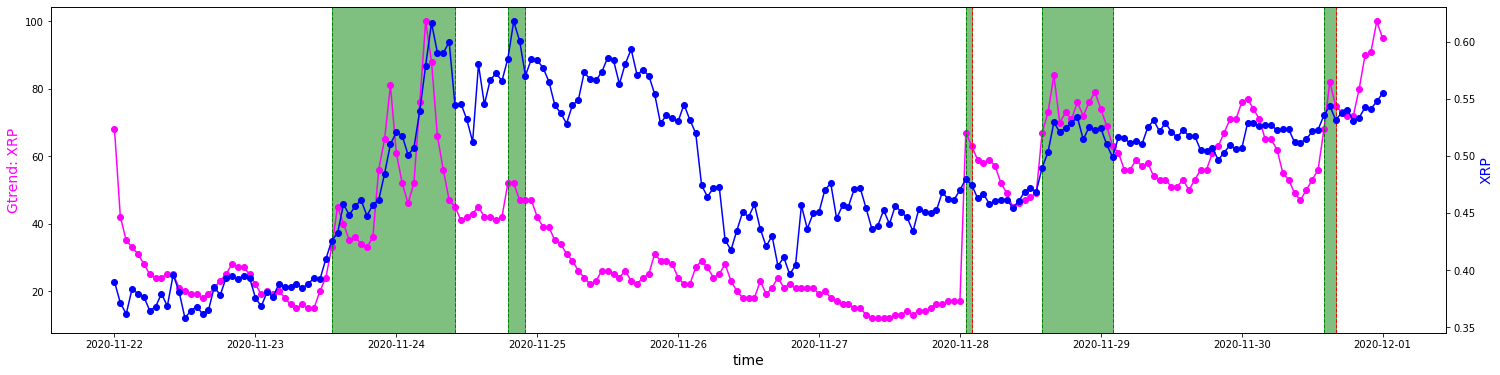

In [ ]:
#XRP coin
#FTM coin
#ADA coin
#EOS coin
#DOGE coin

trend_words = 'XRP'# token'
currency = 'XRP'
base_currency = 'EUR'


bgn = '2020-11-22'
end = '2020-12-01'


crypto = get_crypto(bgn, end, currency, base_currency)
#print(crypto)
trend = get_trend(bgn, end, trend_words)

#print(trend)
whistle = [[3, 0, -1, -1, 0], [3, 0, -2, -1, 0], [3, -2, -2, 0, 0]]
gain, order = arbitrage(False, whistle)
stat(gain, order)

whistle = [[4, 0, 3, 0, 0], [10, 1, 3, 1, 0], [9, 1, 3, 1, 0]]
#whistle = [[4, 0, 0, 1, 0], [10, 1, 3, 1, 0], [9, 1, 3, 1, 0]]
gain, order = arbitrage(False, whistle)
stat(gain, order)
#smart_arbitre()


plot_crypto_vs_trend(trend, crypto, currency, trend_words, order)
